# Import packages 

In [3]:
import numpy as np
import sympy as sp
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
import scipy
import scipy.optimize as optimize
import random
import time
from scipy.integrate import odeint
from sympy import symbols, solve, simplify
from scipy.optimize import curve_fit, minimize, brute, differential_evolution
from matplotlib.pyplot import cm
from decimal import *

plt.rcParams.update({'font.size': 10})

# Model 


Define the standard values of the parameters

In [6]:
# Normalized concentration of molecules c_v = [FGF]/[FGF]_0, e_v = [eph]/[eph]_0
c_v =  5  
e_v =  5 

# Total number of molecules in each cell
Rt_v =  2000 # Total number of FGF receptors
Qt_v =  2000 # Total number of ephrin receptors
Erkt_v= 4000 # Total number of ERK molecules

# Values of the reaction rates  
Kd =  60 
kd_plus_v = 0.1  
kd_minus_v = Kd*kd_plus_v
 
Ke =  40 
ke_plus_v = 0.1 
ke_minus_v = Ke*ke_plus_v

k_v =  0.2
Vs_v=  1*k_v 
Vrg_v = 0.4*k_v

# Values of half saturation constants
Ks_v =  200  
Krg_v =  200 

# Parameters input distribution (Lognormal distr centered around mu_c, with variance sigma_F^2)
mu_c = 5 
sigma_F =1

# Cell surface
Scell_v = 6000 # Total cell surface (um^2)
S1max = Scell_v/2 # Maximum surface exposed to FGF
S1_v = 0.5*Scell_v # Surface exposed to FGF (um^2)

# The surface exposed to FGF (S1) is related to the surface exposed to ephrin (S2) through:
# S2 = A*S1+B*Scell  (Eq.5) 
A = -1.1265
B = 0.9092

Function to compute the number of active ERK molecules ($E^*$) (Eq. 1-3)

In [8]:
# Function to compute ERK as a function of the input 
def ERK(S1, args):

    kd_plus, kd_minus, ke_plus, ke_minus, c, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args
    
    A = - 1.1265
    B = 0.9092

    S2= A*S1 +B*Scell
    Rb_ss = Rt*S1/Scell*c/(c+kd_minus/kd_plus)
    Qb_ss = Qt*S2/Scell*e/(e+ke_minus/ke_plus)
    Erk_ss = Erkt* (Vs*Rb_ss**2/(Rb_ss**2+Ks**2)) /(Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg)+ k)
        
    return Erk_ss

Function to compute the noise in the number of active ERK molecules ($\sigma_e$) (Eq. 22 - 28)

In [10]:
def sigma(S1, args):
    
    kd_plus, kd_minus, ke_plus, ke_minus, c, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args
    
    A = -1.1265
    B = 0.9092
    Pi = np.pi
    
    S2= A*S1 +B*Scell
    Rb_ss = Rt*S1/Scell*c/(c+kd_minus/kd_plus)
    Qb_ss = Qt*S2/Scell*e/(e+ke_minus/ke_plus)
    Erk_ss = Erkt* (Vs*Rb_ss**2/(Rb_ss**2+Ks**2)) /(Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg)+ k)

    Tau_c = (kd_plus*c+kd_minus)**(-1)
    Tau_e = (ke_plus*e+ke_minus)**(-1)
    Tau_E = (k + Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg) )**(-1)

    Gamma_R = 2*Vs*Rb_ss*Ks**2/(Rb_ss**2+Ks**2)**2*(Erkt-Erk_ss)
    Gamma_Q = Vrg*Krg/(Qb_ss+Krg)**2*Erk_ss

    n_ss = c*kd_plus/(kd_minus + c*kd_plus)
    m_ss = e*ke_plus/(ke_minus + e*ke_plus)

    A_R = 2/Tau_c*Rt*S1/Scell*n_ss*(1-n_ss)
    A_Q = 2/Tau_e*Qt*S2/Scell*m_ss*(1-m_ss)
    A_E = 2*Vs*Rb_ss**2/(Rb_ss**2+Ks**2)*(Erkt-Erk_ss)

    sigma_R = Gamma_R**2*A_R/2*(Tau_c-Tau_E)/(Tau_E**(-2)-Tau_c**(-2))
    sigma_Q = Gamma_Q**2*A_Q/2*(Tau_e-Tau_E)/(Tau_E**(-2)-Tau_e**(-2))
    sigma_E = A_E/2*Tau_E

    sigma2 = sigma_R + sigma_Q + sigma_E
        
    return np.float32(np.sqrt(sigma2))


Function to compute the derivative $dE^*/dS_1$

In [12]:
# Compute the derivative of ERK with respect to the input 
def dERK(S1, args):
    
    kd_plus, kd_minus, ke_plus, ke_minus, c, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args
    
    A = -1.1265
    B = 0.9092
    
    S2= A*S1 +B*Scell
    Rb_ss = Rt*S1/Scell*c/(c+kd_minus/kd_plus)
    Qb_ss = Qt*S2/Scell*e/(e+ke_minus/ke_plus)
    Erk_ss = Erkt* (Vs*Rb_ss**2/(Rb_ss**2+Ks**2)) /(Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg)+ k)

    A_R = Vs*Rb_ss**2/(Rb_ss**2+Ks**2)
    A_Q = Vrg*Qb_ss/(Qb_ss+Krg)
    
    dAR_dRb = Vs*2*Ks**2*Rb_ss/(Rb_ss**2+Ks**2)**2
    dAQ_dQb = Vrg*Krg/(Qb_ss+Krg)**2
    
    dRb_dS1 = Rt/Scell*c/(c+kd_minus/kd_plus)
    dQb_dS1 = -Qt*A/Scell*e/(e+ke_minus/ke_plus)
    
    dE_dS1 = Erkt* ((A_Q+k)*dAR_dRb*dRb_dS1 - A_R*dAQ_dQb*dQb_dS1)/(A_R+A_Q+k)**2 
        
    return dE_dS1

## Information transmission

Function to define the vector of S1 

In [15]:
def inputrangeS1(S1_max, lb= -5, num=50):
    S1m = 10**S1_max
    
    S1_temp1= np.logspace(lb, S1_max,num)
    S1_temp2= S1m-S1_temp1
    
    S1_temp= np.sort(np.concatenate((S1_temp1, S1_temp2), 0))

    return S1_temp

Function to compute the maximal information transmitted between ERK and S1 ($I^*$), and the optimal distribution ($P^*(S_1)$)

In [17]:
 # The only constraint on the distribution is normalization
def maxInfo(S1, args):
    
    kd_plus, kd_minus, ke_plus, ke_minus, c, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args
    
    Erk = ERK(S1, args=args) 
    sigm = sigma(S1, args=args)
    dErk = dERK(S1, args=args)
    
    P = np.abs(dErk)/(sigm*np.sqrt(2*np.pi*np.exp(1)))
    Z = np.trapz(P,S1)
    Pstar = P/Z 
    I= np.log2(Z) 
    
    return I, Pstar

Function to compute the maximal information transmitted between ERK and S1 ($I^*$), and the optimal distribution ($P^*(S_1)$) in the presence of the external constraint $S_1^{tot}$: $<S_1> = S_1^{tot}$

In [19]:
# Constraints: the optimal distribution of inputs is normalised & <S1> = S1tot
def maxInfo_S1tot(S1, args, S1tot= 100, la=1e-2, lb=0, th= 100):
        
    Scell = args[-1]
    
    # Check that S1tot < Scell
    if S1tot > Scell:
        return 'S1tot is too high'
    
    Erk = ERK(S1, args=args) 
    sigm = sigma(S1, args=args)
    dErk = dERK(S1, args=args)
    
    # Find the best value of l with the bisection method:
    
    # Check that <S1>(la) < S1tot and  <S1>(lb) > S1tot
    Pa = 1/np.sqrt(2*np.pi*np.exp(1))*np.abs(dErk)/sigm*np.exp(-la*S1) # Compute the opt distrib for l=la
    Pb = 1/np.sqrt(2*np.pi*np.exp(1))*np.abs(dErk)/sigm*np.exp(-lb*S1) # Compute the opt distrib for l=lb
    
    Za = np.trapz(Pa,S1) # Compute the normalization constant
    Zb = np.trapz(Pb,S1)
    
    S1mean_a = np.trapz(Pa/Za*S1, S1) # Compute <S1>(la)
    S1mean_b = np.trapz(Pb/Zb*S1, S1) # Compute <S1>(lb)
    
    if S1mean_a > S1tot: 
        print('<S1>(la)=',S1mean_a)
        return 'The lower bound on l (la) is too low'
        
    if S1mean_b < S1tot: 
        print('<S1>(lb)=',S1mean_b)
        return 'The upper bound on l (lb) is too high'
    
    lc = (la+lb)/2
    Pc = 1/np.sqrt(2*np.pi*np.exp(1))*np.abs(dErk)/sigm*np.exp(-lc*S1) # Compute the opt distrib for l=lc
    Zc = np.trapz(Pc,S1)
    S1mean_c = np.trapz(Pc/Zc*S1, S1) # Compute <S1>(lc)
    
    diff0 = np.abs(S1tot- S1mean_c).tolist()
    diff = np.abs(S1tot- S1mean_c).tolist()

    while (diff>= th): 
        lc = (la+lb)/2
        Pa = 1/np.sqrt(2*np.pi*np.exp(1))*np.abs(dErk)/sigm*np.exp(-la*S1) # Compute the opt distrib for l=la
        Za = np.trapz(Pa,S1)
        S1mean_a = np.trapz(Pa/Za*S1, S1) # Compute <S1>(la)
        
        Pc = 1/np.sqrt(2*np.pi*np.exp(1))*np.abs(dErk)/sigm*np.exp(-lc*S1) # Compute the opt distrib for l=lc
        Zc = np.trapz(Pc,S1)
        S1mean_c = np.trapz(Pc/Zc*S1, S1) # Compute <S1>(lc)
        
        diff = np.abs(S1tot- S1mean_c).tolist()
        
        if S1tot > S1mean_c:
            la=lc
        else:
            lb=lc
    
    l = lc
    
    # Compute the optimal distr and the max information
    P = 1/np.sqrt(2*np.pi*np.exp(1))*np.abs(dErk)/sigm*np.exp(-l*S1)
    Z = np.trapz(P,S1) 
    S1mean = np.trapz(P/Z*S1, S1) 
    I= np.log2(Z)+l/np.log(2)*S1tot
    
    return I, P/Z


# Figures

## Fig. 5

Compute the optimal distribution $P^*(S_1)$ in the absence of external constraints

In [23]:
Scell_v = 6000 
Smax = 1/2*Scell_v 
S1_temp = np.logspace(-7, np.log10(Smax), 500) 

c_v = 40
S1tot_v= 200

args = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, c_v, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, Scell_v]

# Compute the maximal information transmitted and the optiamal input distribution
I, PS1_S1tot = maxInfo(S1_temp, args)

# Compute ERK(S1)
E_temp = ERK(S1_temp, args) 

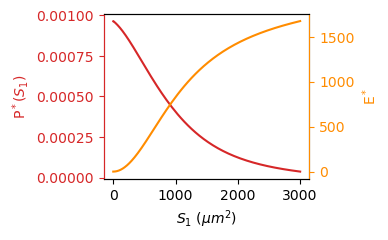

In [24]:
# Figure
fig, ax1 = plt.subplots(figsize=(3.9,2.5))

color1 = 'tab:red'
color2 = 'darkorange'

ax1.set_xlabel('$S_1$ ($\\mu m^2$)', fontsize=10)
ax1.set_ylabel('P$^*$($S_1$)', fontsize=10, color=color1) 
ax1.plot(S1_temp, PS1_S1tot, color=color1, linewidth=1.5)
ax1.tick_params(axis='y', labelcolor=color2)
ax1.spines['left'].set_color(color1)
ax1.tick_params(axis='y', colors=color1) 

ax2 = ax1.twinx()  
ax2.set_ylabel('E$^*$', fontsize=10, color=color2)  

plt.plot(S1_temp, E_temp, '-', color=color2, linewidth=1.5)
ax2.spines['left'].set_color(color1)
ax2.spines['right'].set_color(color2)
ax2.tick_params(axis='y', colors=color2)

fig.tight_layout() 
plt.show()

## Fig. 6

Compute the maximal information transmitted for different values of the constraint $<S_1> = S_1^{tot}$

In [27]:
S1tot_temp = np.linspace(50,3000, 40)

Smax= Scell_v
S1_temp = inputrangeS1( np.log10(Smax),lb= -15, num=200)[1:] 

args = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, c_v, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, Scell_v]

# Compute the maximal transmitted information as a function of S1tot
I_S1tot = []
Pstar_S1tot = []   
for i in range(len(S1tot_temp)):
    IS1_max_S1tot, PS1_S1tot = maxInfo_S1tot(S1_temp, args, S1tot= S1tot_temp[i], la=1e0, lb=-1e-1, th=0.1)
    I_S1tot.append(IS1_max_S1tot)
    Pstar_S1tot.append(PS1_S1tot)


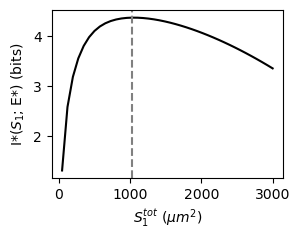

In [28]:
# Figure 
color = cm.YlOrRd(np.linspace(0.1, 1, len(S1tot_temp)))

plt.figure(figsize=(3.1,2.5))
plt.plot(S1tot_temp, I_S1tot, '-', color='k',label='$I^*(S_1^{tot})$')
plt.ylabel('I*($S_1$; E*) (bits)')
plt.xlabel('$S_1^{tot}$ $(\\mu m^2)$')

plt.axvline(x= S1tot_temp[np.where(I_S1tot== np.max(I_S1tot))], linestyle= '--', color='grey')

plt.tight_layout()
plt.show()